In [1]:
import sys
sys.path.append('..')

import os
import numpy as np
import time
import joblib
from matplotlib import pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet50_preprocess
from tensorflow.keras.preprocessing import image

from project.config import FEATURES_FOLDER, MODELS_FOLDER

In [2]:
root_dir = FEATURES_FOLDER + "/"
base_dir = root_dir + "mel_fe/"
train_dir = base_dir + "training/"
val_dir = base_dir + "validation/"
test_dir = base_dir + "test/"

input_shape = (224, 224)
batch_size = 32

cut_level = "block5_pool" #"conv5_block1_2_relu"
net = 'vgg16' #"resnet50"
preprocess_input = vgg16_preprocess if net == "vgg16" else resnet50_preprocess
features_filename = 'features_vgg16_block5_pool.npy' #"features_resnet50_conv5_block1_2_relu.npy"


In [3]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(input_shape[0], input_shape[1]),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    class_mode="sparse",
    subset="training",
)

test_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(input_shape[0], input_shape[1]),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    class_mode="sparse",
    subset="validation",
)

y_train = train_generator.classes
y_test = test_generator.classes


Found 6398 images belonging to 8 classes.
Found 1596 images belonging to 8 classes.


In [4]:
if net == "vgg16":
    base_model = VGG16(weights="imagenet")
elif net == "resnet50":
    base_model = ResNet50(weights="imagenet")
base_model.summary()

2022-01-24 21:40:25.119451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 21:40:25.143737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 21:40:25.143921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 21:40:25.144360: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
base_model = keras.Model(base_model.input, base_model.get_layer(cut_level).output)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
def extract_features(model, datagen):
    features = model.predict_generator(datagen)
    features = features.reshape((features.shape[0], -1))
    return features

def pre_process(features, std_scaler, pca_scaler):
    if std_scaler == None:
        std_scaler = StandardScaler()
        std_scaler.fit(features)

    if pca_scaler == None:
        pca_scaler = PCA(0.90)
        pca_scaler.fit(features)

    features = std_scaler.transform(features)
    features = pca_scaler.transform(features)
    return features, std_scaler, pca_scaler


def train(features, labels, model, grid_params):
    t_start = time.time()

    clf = GridSearchCV(model, grid_params, scoring="accuracy", n_jobs=-1, cv=10)
    clf.fit(features, labels)

    time_train = time.time() - t_start
    print("time_{}_train: --- {} seconds ---".format("model", time_train))
    print("best_params: {}".format(clf.best_params_))
    print("Accuracy: {}".format(clf.best_score_))
    return clf


def test(clf, features, labels):
    start = time.perf_counter()
    pred = clf.predict(features)
    print("time_{}test: --- {} seconds ---".format("model", time.perf_counter() - start))

    fig, ax = plt.subplots(figsize=(6, 6))
    disp = metrics.ConfusionMatrixDisplay(
        metrics.confusion_matrix(labels, pred), display_labels=range(8)
    )
    disp.plot(ax=ax, colorbar=False, cmap="Blues")

    print("{}".format(metrics.classification_report(labels, pred)))
    print("Accuracy: {}".format(metrics.accuracy_score(labels, pred)))


In [ ]:
features_path = os.path.join(FEATURES_FOLDER, "deep_features", features_filename)
if os.path.isfile(features_path):
    features = np.load(features_path)
else:
    features = extract_features(base_model, train_generator)
    np.save(features_path, features)

X_train, std_scaler, pca_scaler = pre_process(features, None, None)
X_train.shape


# Linear SVM

In [ ]:
svm_params = {"C": [0.01, 0.1, 1, 10]}
clf = train(X_train, y_train, LinearSVC(), svm_params)


In [ ]:
X_test, _, _ = pre_process(
    extract_features(base_model, test_generator), std_scaler, pca_scaler
)
print(X_test.shape)
test(clf, X_test, y_test)


# RBF SVM

In [ ]:
svm_params = {"C": [0.01, 0.1, 1, 10], "gamma": [0.01, 0.001, 0.0001]}
clf = train(X_train, y_train, SVC(kernel="rbf"), svm_params)


In [ ]:
X_test, _, _ = pre_process(
    extract_features(base_model, test_generator), std_scaler, pca_scaler
)
print(X_test.shape)
test(clf, X_test, y_test)

# joblib.dump([std_scaler, pca_scaler, clf], 'best_resnet50.sav', compress=1)
# joblib.dump([std_scaler, pca_scaler, clf], 'best_vgg16.sav', compress=1)


# NN

In [ ]:
nn_params = {
    "hidden_layer_sizes": [(512, 256), (512, 32), (512,)],
    "alpha": [0.01, 0.03, 0.05],
}
clf = train(
    X_train,
    y_train,
    MLPClassifier(activation="relu", solver="adam", batch_size=32, early_stopping=True),
    nn_params,
)


In [ ]:
X_test, _, _ = pre_process(
    extract_features(base_model, test_generator), std_scaler, pca_scaler
)
print(X_test.shape)
test(clf, X_test, y_test)


# Validation

2022-01-24 21:40:37.520343: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


(1596, 1174)
time_modeltest: --- 4.517808397999943 seconds ---
              precision    recall  f1-score   support

           0       0.46      0.56      0.51       199
           1       0.47      0.40      0.43       199
           2       0.51      0.63      0.56       200
           3       0.60      0.60      0.60       199
           4       0.41      0.31      0.35       200
           5       0.58      0.73      0.65       200
           6       0.33      0.24      0.28       200
           7       0.52      0.51      0.51       199

    accuracy                           0.50      1596
   macro avg       0.49      0.50      0.49      1596
weighted avg       0.49      0.50      0.49      1596

Accuracy: 0.4968671679197995


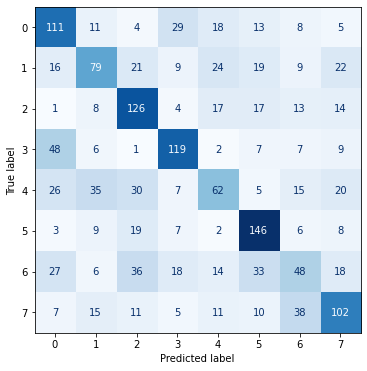

In [7]:
#load model
[std_scaler, pca_scaler, best_model] = joblib.load(os.path.join(MODELS_FOLDER, 'best_vgg16.sav'))

X_test, _, _ = pre_process(extract_features(base_model, test_generator), std_scaler, pca_scaler)
print(X_test.shape)
test(best_model, X_test, y_test)


In [22]:
from project.utils.nn import prediction_time
t1 = prediction_time(base_model, input_shape=(224, 224, 3), device_name="/cpu:0")
t2 = prediction_time(base_model, input_shape=(224, 224, 3), device_name="/gpu:0")
print(t1)
print(t2)

71.82624289998785
21.837126199898194


In [29]:
def prediction_time_ml(model, input_shape):
    dummy_example = np.random.randn(*input_shape)
    times = []
    for i in range(10):
        start = time.perf_counter()
        model.predict(dummy_example)
        end = time.perf_counter() - start
        times.append(end)
    times = np.asarray(times)
    return np.mean(times) * 1000

t3 = prediction_time_ml(best_model, input_shape=(1, 1321))
print(t3)

3.187206500024331
